In [6]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# variables for the weather api
# hourly and daily needs to be chosen from
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.5167,
	"longitude": 9.9167,
	"start_date": "2018-01-01",
	"end_date": "2024-11-03",
	"hourly": ["temperature_2m", "cloud_cover"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["cloud_cover"] = hourly_cloud_cover

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


# save file in csv

csv_file = "daily_weather.csv"
hourly_dataframe.to_csv(csv_file, index = False)

Coordinates 51.49384689331055°N 9.945652961730957°E
Elevation 174.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           date  temperature_2m  cloud_cover
0     2018-01-01 00:00:00+00:00          10.383        100.0
1     2018-01-01 01:00:00+00:00           9.433        100.0
2     2018-01-01 02:00:00+00:00           8.583        100.0
3     2018-01-01 03:00:00+00:00           7.933         66.0
4     2018-01-01 04:00:00+00:00           7.583         93.0
...                         ...             ...          ...
59971 2024-11-03 19:00:00+00:00             NaN          NaN
59972 2024-11-03 20:00:00+00:00             NaN          NaN
59973 2024-11-03 21:00:00+00:00             NaN          NaN
59974 2024-11-03 22:00:00+00:00             NaN          NaN
59975 2024-11-03 23:00:00+00:00             NaN          NaN

[59976 rows x 3 columns]


Nicht Relevant

In [23]:
import pandas as pd

# Read CSV
energy_prices = pd.read_csv("day_ahead_energy_prices.csv", parse_dates=["date"], index_col="date")
weather = pd.read_csv("daily_weather.csv", parse_dates=["date"], index_col="date")

# merge data 
data = energy_prices.join(weather, how="inner")

# seperate time
data['hour'] = data.index.hour
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

# mixed value preperation
data = data.interpolate(method='time')


# save file in csv

csv_file = "data_combined.csv"
hourly_dataframe.to_csv(csv_file, index = False)



In [37]:
import pandas as pd
from datetime import timedelta

# CSV-Daten einlesen und sicherstellen, dass `date` die Index-Spalte ist
energy_prices = pd.read_csv("day_ahead_energy_prices.csv", parse_dates=["date"], index_col="date")

# Zeitzone entfernen, um mögliche Filterprobleme zu vermeiden
energy_prices.index = energy_prices.index.tz_localize(None)

# Überprüfen, ob der Datumsindex korrekt gesetzt wurde und keine Zeitzone mehr enthält
print("Erster Eintrag im Datensatz:")
print(energy_prices.head())
print("\nDatentyp des Indexes:", energy_prices.index.dtype)  # Sollte `datetime64[ns]` sein, ohne Zeitzone

# Start- und Enddatum festlegen: Letzte 6 Monate relativ zum letzten Datum im Datensatz
end_date = energy_prices.index.max()
start_date = end_date - timedelta(days=6*30)  # Ungefähre 6 Monate

# Daten der letzten 6 Monate basierend auf Start- und Enddatum filtern
energy_prices_6m = energy_prices.loc[start_date:end_date]
print("\nAnzahl der Datenpunkte durch manuelles Filtern:", energy_prices_6m.shape[0])

# Alternative Methode: Die letzten 180 Tage direkt auswählen
energy_prices_last_180d = energy_prices.last("180D")
print("\nAnzahl der Datenpunkte durch `.last(180D)`:", energy_prices_last_180d.shape[0])

# Ergebnis überprüfen
print("\nGefilterte Daten (manuelles Filtern):")
print(energy_prices_6m.head())

print("\nGefilterte Daten (mit `.last(180D)`):")
print(energy_prices_last_180d.head())


Erster Eintrag im Datensatz:
                     hourly day-ahead energy price
date                                              
2024-10-29 22:00:00                         103.09
2024-10-29 21:00:00                         118.08
2024-10-29 20:00:00                         124.05
2024-10-29 19:00:00                         140.60
2024-10-29 18:00:00                         203.82

Datentyp des Indexes: datetime64[ns]

Anzahl der Datenpunkte durch manuelles Filtern: 0

Anzahl der Datenpunkte durch `.last(180D)`: 83881

Gefilterte Daten (manuelles Filtern):
Empty DataFrame
Columns: [hourly day-ahead energy price]
Index: []

Gefilterte Daten (mit `.last(180D)`):
                     hourly day-ahead energy price
date                                              
2024-10-29 22:00:00                         103.09
2024-10-29 21:00:00                         118.08
2024-10-29 20:00:00                         124.05
2024-10-29 19:00:00                         140.60
2024-10-29 18:00:00    

C:\Users\elias\AppData\Local\Temp\ipykernel_9916\2985455991.py:24: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  energy_prices_last_180d = energy_prices.last("180D")


Use Prophet from Facebook


In [ ]:
#pip install prophet

17:12:25 - cmdstanpy - INFO - Chain [1] start processing
17:15:54 - cmdstanpy - INFO - Chain [1] done processing


                       ds       yhat  yhat_lower  yhat_upper
53400 2025-02-02 22:00:00  25.344059  -45.176300  101.483666
53401 2025-02-03 22:00:00  42.781920  -33.215493  121.153964
53402 2025-02-04 22:00:00  18.220151  -58.532466   95.027991
53403 2025-02-05 22:00:00  29.159695  -51.011327  114.593502
53404 2025-02-06 22:00:00  29.412476  -48.749531  109.363267


NameError: name 'go' is not defined

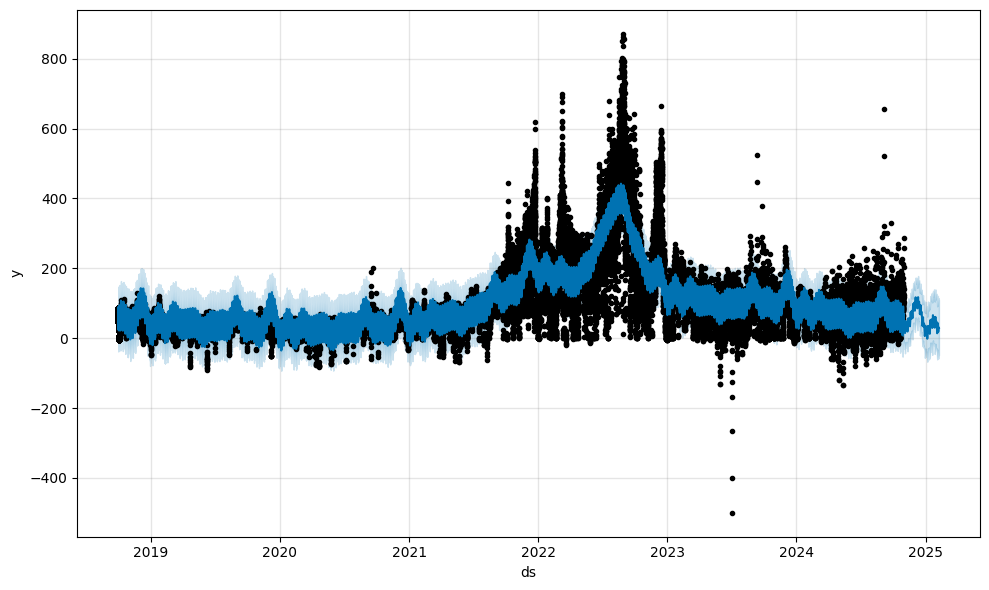

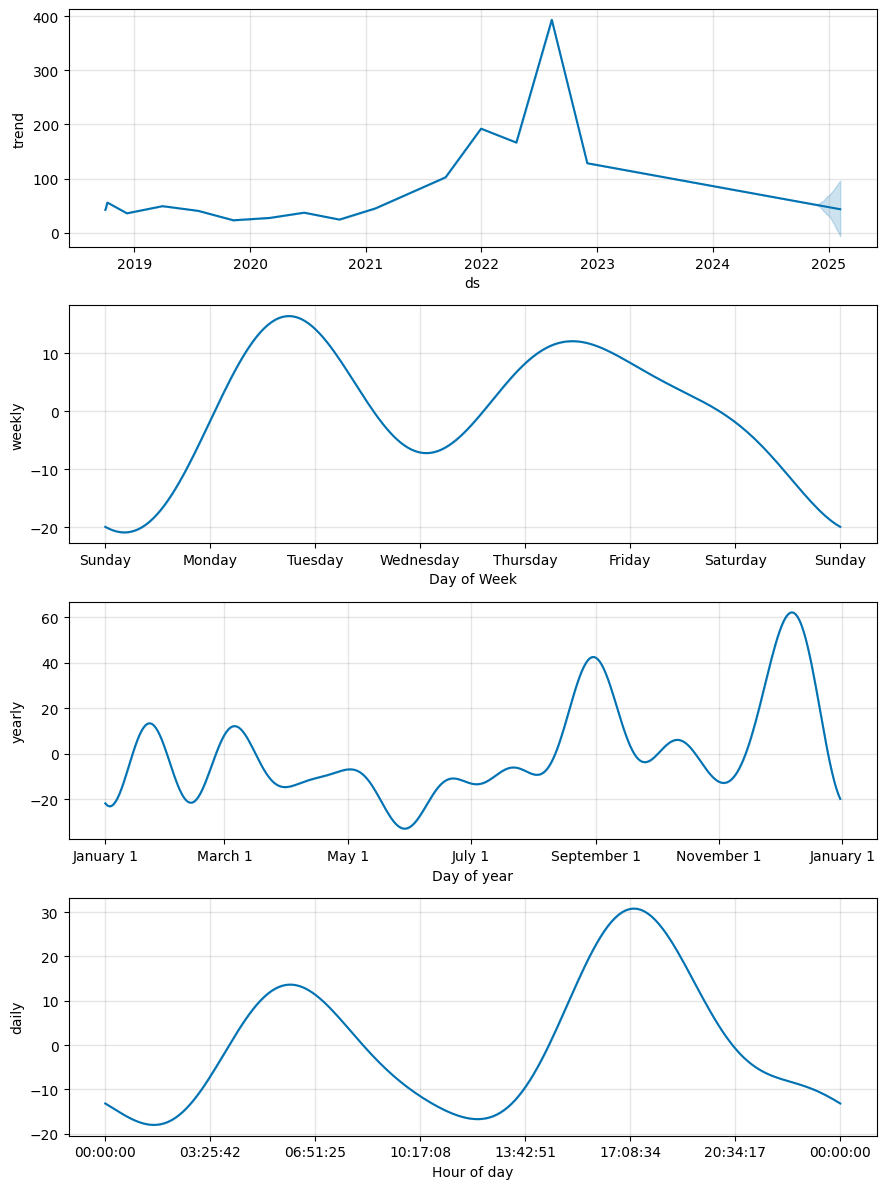

In [12]:
import pandas as pd
from prophet import Prophet

# CSV-Daten einlesen
energy_prices = pd.read_csv("day_ahead_energy_prices.csv")

# Spalten für Prophet umbenennen: 'date' -> 'ds' und 'hourly day-ahead energy price' -> 'y'
energy_prices = energy_prices.rename(columns={"date": "ds", "hourly day-ahead energy price": "y"})

# Zeitzone aus der 'ds'-Spalte entfernen
energy_prices['ds'] = pd.to_datetime(energy_prices['ds']).dt.tz_localize(None)

# Prophet-Modell initialisieren und trainieren
m = Prophet()
m.fit(energy_prices)

# Zukünftige Daten erstellen (365 Tage in die Zukunft)
future_price = m.make_future_dataframe(periods=100)

# Prognose für zukünftige Daten berechnen
forecast = m.predict(future_price)

# Ergebnis anzeigen
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Prognoseplot
figure1 = m.plot(forecast)


figure2 = m.plot_components(forecast)


from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)


# Python
plot_components_plotly(m, forecast)

